Collaborator: Abdullah Khurram 

In [1]:
import pygame
from pygame import gfxdraw
import numpy as np
from numpy.random import randint
from scipy.spatial import distance
from collections import deque
from copy import deepcopy
import scipy.stats as sts

pygame 2.1.2 (SDL 2.0.18, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Simulation 

### 1. Pygame Window

In [2]:
#This code has been taken from https://github.com/BilHim/trafficSimulator/blob/main/src/trafficSimulator/window.py. 
#A few changes were made in the code to customize it for my strategy 

class Window:
    """
    This class contains all the relevant methods to draw the simulation in Pygame. 
    
    Args:
        sim (class) : the simulation we want to visualise 
        config (dictionary): configuration for the simulation, can include things like height, width, color, etc. 
    
    Returns:
        A pygame window popup to show the simulation
    
    """
    def __init__(self, sim, config={}):
        # Simulation to draw
        self.sim = sim

        # Set default configurations
        self.set_default_config()

        # Update configurations
        for attr, val in config.items():
            setattr(self, attr, val)
        
    def set_default_config(self):
        """Set default configuration"""
        self.width = 900
        self.height = 600
        self.bg_color = (250, 250, 250)

        self.fps = 60
        self.zoom = 5
        self.offset = (0, 0)

        self.mouse_last = (0, 0)
        self.mouse_down = False

    def convert(self, x, y=None):
        """Converts simulation coordinates to screen coordinates"""
        if isinstance(x, list):
            return [self.convert(e[0], e[1]) for e in x]
        if isinstance(x, tuple):
            return self.convert(*x)
        return (
            int(self.width/2 + (x + self.offset[0])*self.zoom),
            int(self.height/2 + (y + self.offset[1])*self.zoom)
        )

    def inverse_convert(self, x, y=None):
        """Converts screen coordinates to simulation coordinates"""
        if isinstance(x, list):
            return [self.convert(e[0], e[1]) for e in x]
        if isinstance(x, tuple):
            return self.convert(*x)
        return (
            int(-self.offset[0] + (x - self.width/2)/self.zoom),
            int(-self.offset[1] + (y - self.height/2)/self.zoom)
        )


    def background(self, r, g, b):
        """Fills screen with one color."""
        self.screen.fill((r, g, b))

    def line(self, start_pos, end_pos, color):
        """Draws a line."""
        gfxdraw.line(
            self.screen,
            *start_pos,
            *end_pos,
            color
        )

    def rect(self, pos, size, color):
        """Draws a rectangle."""
        gfxdraw.rectangle(self.screen, (*pos, *size), color)

    def box(self, pos, size, color):
        """Draws a rectangle."""
        gfxdraw.box(self.screen, (*pos, *size), color)

    def circle(self, pos, radius, color, filled=True):
        gfxdraw.aacircle(self.screen, *pos, radius, color)
        if filled:
            gfxdraw.filled_circle(self.screen, *pos, radius, color)



    def polygon(self, vertices, color, filled=True):
        gfxdraw.aapolygon(self.screen, vertices, color)
        if filled:
            gfxdraw.filled_polygon(self.screen, vertices, color)

    def rotated_box(self, pos, size, angle=None, cos=None, sin=None, centered=True, color=(247, 194, 2), filled=True):
        """Draws a rectangle center at *pos* with size *size* rotated anti-clockwise by *angle*."""
        x, y = pos
        l, h = size

        if angle:
            cos, sin = np.cos(angle), np.sin(angle)
        
        vertex = lambda e1, e2: (
            x + (e1*l*cos + e2*h*sin)/2,
            y + (e1*l*sin - e2*h*cos)/2
        )

        if centered:
            vertices = self.convert(
                [vertex(*e) for e in [(-1,-1), (-1, 1), (1,1), (1,-1)]]
            )
        else:
            vertices = self.convert(
                [vertex(*e) for e in [(0,-1), (0, 1), (2,1), (2,-1)]]
            )

        self.polygon(vertices, color, filled=filled)

    def rotated_rect(self, pos, size, angle=None, cos=None, sin=None, centered=True, color=(247, 194, 2)):
        self.rotated_box(pos, size, angle=angle, cos=cos, sin=sin, centered=centered, color=color, filled=False)

    def arrow(self, pos, size, angle=None, cos=None, sin=None, color=(179, 177, 173)):
        if angle:
            cos, sin = np.cos(angle), np.sin(angle)
        
        self.rotated_box(
            pos,
            size,
            cos=(cos - sin) / np.sqrt(2),
            sin=(cos + sin) / np.sqrt(2),
            color=color,
            centered=False
        )

        self.rotated_box(
            pos,
            size,
            cos=(cos + sin) / np.sqrt(2),
            sin=(sin - cos) / np.sqrt(2),
            color=color,
            centered=False
        )


    def draw_axes(self, color=(100, 100, 100)):
        x_start, y_start = self.inverse_convert(0, 0)
        x_end, y_end = self.inverse_convert(self.width, self.height)
        self.line(
            self.convert((0, y_start)),
            self.convert((0, y_end)),
            color
        )
        self.line(
            self.convert((x_start, 0)),
            self.convert((x_end, 0)),
            color
        )

    def draw_grid(self, unit=50, color=(150,150,150)):
        x_start, y_start = self.inverse_convert(0, 0)
        x_end, y_end = self.inverse_convert(self.width, self.height)

        n_x = int(x_start / unit)
        n_y = int(y_start / unit)
        m_x = int(x_end / unit)+1
        m_y = int(y_end / unit)+1

        for i in range(n_x, m_x):
            self.line(
                self.convert((unit*i, y_start)),
                self.convert((unit*i, y_end)),
                color
            )
        for i in range(n_y, m_y):
            self.line(
                self.convert((x_start, unit*i)),
                self.convert((x_end, unit*i)),
                color
            )

    def draw_roads(self):
        for road in self.sim.roads:
            # Draw road background
            self.rotated_box(
                road.start,
                (road.length, 10),
                cos=road.angle_cos,
                sin=road.angle_sin,
                color=(64, 64, 62),
                centered=False
            )
            if road.length > 5: 
                for i in np.arange(-0.5*road.length, 0.5*road.length, 10):
                    pos = (
                        road.start[0] + (road.length/2 + i + 3) * road.angle_cos,
                        road.start[1] + (road.length/2 + i + 3) * road.angle_sin
                    )

                    self.arrow(
                        pos,
                        (-1.25, 0.2),
                        cos=road.angle_cos,
                        sin=road.angle_sin
                    )   
            
    def draw_vehicle(self, vehicle, road):
        l, h = vehicle.l,  2
        sin, cos = road.angle_sin, road.angle_cos

        x = road.start[0] + cos * vehicle.x 
        y = road.start[1] + sin * vehicle.x 

        self.rotated_box((x, y), (l, h), cos=cos, sin=sin, centered=True)

    def draw_vehicles(self):
        for road in self.sim.roads:
            # Draw vehicles
            for vehicle in road.vehicles:
                self.draw_vehicle(vehicle, road)

    def draw_signals(self):
        for signal in self.sim.traffic_signals:
            for i in range(len(signal.roads)):
                color = (0, 255, 0) if signal.current_cycle[i] else (255, 0, 0)
                for road in signal.roads[i]:
                    a = 0
                    position = (
                        (1-a)*road.end[0] + a*road.start[0],        
                        (1-a)*road.end[1] + a*road.start[1]
                    )
                    self.rotated_box(
                        position,
                        (1, 3),
                        cos=road.angle_cos, sin=road.angle_sin,
                        color=color)

    def draw_status(self):
        text_fps = self.text_font.render(f't={self.sim.t:.5}', False, (0, 0, 0))
        text_frc = self.text_font.render(f'n={self.sim.frame_count}', False, (0, 0, 0))
        
        self.screen.blit(text_fps, (0, 0))
        self.screen.blit(text_frc, (100, 0))


    def draw(self):
        # Fill background
        self.background(*self.bg_color)
        self.draw_roads()
        self.draw_vehicles()
        self.draw_signals()
        self.draw_status()
        

    def loop(self, loop=None):
        """Shows a window visualizing the simulation and runs the loop function."""
        
        # Create a pygame window
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.flip()

        # Fixed fps
        clock = pygame.time.Clock()

        # To draw text
        pygame.font.init()
        self.text_font = pygame.font.SysFont('Lucida Console', 16)
        
        # Draw loop
        running = True
        while running:
            # Update simulation
            if loop: loop(self.sim)

            # Draw simulation
            self.draw()

            # Update window
            pygame.display.update()
            clock.tick(self.fps)

            # Handle all events
            for event in pygame.event.get():
                # Quit program if window is closed
                if event.type == pygame.QUIT:
                    running = False
                    pygame.quit()
                # Handle mouse events
                elif event.type == pygame.MOUSEBUTTONDOWN:
                    # If mouse button down
                    if event.button == 1:
                        # Left click
                        x, y = pygame.mouse.get_pos()
                        x0, y0 = self.offset
                        self.mouse_last = (x-x0*self.zoom, y-y0*self.zoom)
                        self.mouse_down = True
                    if event.button == 4:
                        # Mouse wheel up
                        self.zoom *=  (self.zoom**2+self.zoom/4+1) / (self.zoom**2+1)
                    if event.button == 5:
                        # Mouse wheel down 
                        self.zoom *= (self.zoom**2+1) / (self.zoom**2+self.zoom/4+1)
                elif event.type == pygame.MOUSEMOTION:
                    # Drag content
                    if self.mouse_down:
                        x1, y1 = self.mouse_last
                        x2, y2 = pygame.mouse.get_pos()
                        self.offset = ((x2-x1)/self.zoom, (y2-y1)/self.zoom)
                elif event.type == pygame.MOUSEBUTTONUP:
                    self.mouse_down = False           

    def run(self, steps_per_update=1):
        """Runs the simulation by updating in every loop."""
        def loop(sim):
            sim.run(steps_per_update)
        self.loop(loop)

### 2. Simulation loop

In [3]:
class WindowSimulation:
    """
    This class contains all the relevant methods to run the simulation without creating a pygame pop. 
    
    Args:
        sim (class) : the simulation we want to visualise 
        config (dictionary): configuration for the simulation, can include things like height, width, color, etc. 
    
    """
    
    def __init__(self, sim, config={}):
        # Simulation
        self.sim = sim
        
        # Set default configurations
        self.set_default_config()

        # Update configurations
        for attr, val in config.items():
            setattr(self, attr, val)
        
    def set_default_config(self):
        """Set default configuration"""
        self.fps = 60
        self.running = True

    def loop(self, loop=None, trials = 1):
        """Shows a window visualizing the simulation and runs the loop function."""
        # Fixed fps
        clock = pygame.time.Clock()
        running = self.running
        for i in range(trials):
            # Update simulation
            if loop: loop(self.sim)
            clock.tick(self.fps)         

    def run(self, steps_per_update=1, trials = 100):
        """Runs the simulation by updating in every loop."""
        def loop(sim):
            sim.run(steps_per_update)
        for i in range(trials):
            self.loop(loop)
        self.running = False

## Traffic model

### 1. Nagel–Schreckenberg model

In [4]:
class VehicleNS:
    """
    Creates a vehicle and sets its updating rules. 
    
    Args:
        distribution (distribution): distribution over the speeds of the cars
        v_max (int) : the maximum speed of a car
        config (dictionary): configuration for each vehicle, can include things like length of car or minimum desired distance etc. 
    
    Returns:
        object : a vehicle object with relevant attributes to be on a road
    
    """
    
    def __init__(self, distribution, v_max, config={}):
        # Set default configuration
        self.set_default_config()
        self.v_max = v_max
        self.distribution = distribution
        self.v = self.distribution.rvs()

        # Update configuration
        for attr, val in config.items():
            setattr(self, attr, val)

    def set_default_config(self):    
        self.l = 4 #length of car
        self.s0 = 4 #minimum desired distance between cars
        
        self.path = [] #path followed by the car
        self.current_road_index = 0
        self.p = sts.uniform.rvs(0.1, 0.3)  #a random value from a distribution over probability of random slow down

        self.x = 0 #position 
        self.stopped = False

    def update(self, lead, dt):
        # Update position and velocity
        #self.v = sts.norm.rvs(loc = 1, scale = 0.1)
        if lead:
            delta_x = lead.x - self.x - lead.l
        #acceleration
            if (self.v < self.v_max) and (delta_x > self.v + self.s0): #accelerate only if the car is at a safe distance 
                self.v += 1
        #decceleration
            if self.v >= delta_x - self.s0: #we want the car to dececelerate from a safe difference
                self.v = delta_x - self.s0
        #randomization 
        else: 
            if self.v < self.v_max:
                self.v += 1
        if sts.uniform.rvs(0,1) <= self.p:
            self.v -= 1
        
        self.x += self.v
        

In [5]:
class VehicleGeneratorNS:
    """
    Creates a list of vehicles using the Vechicle class and set of generation rules to appropriately space out 
    creating the vehicles
    
    Args:
        distribution (distribution): distribution over the speeds of the cars
        v_max (int) : the maximum speed of a car
        config (dictionary): configuration for the vehicles, can include things like vehicle rate. 
    
    Returns:
        object : a list of vehicles 
    
    """
    def __init__(self, sim, distribution, v_max, config={}):
        self.sim = sim
        self.distribution = distribution
        self.v_max = v_max

        # Set default configurations
        self.set_default_config()

        # Update configurations
        for attr, val in config.items():
            setattr(self, attr, val)

        # Calculate properties
        self.init_properties()

    def set_default_config(self):
        """Set default configuration"""
        self.vehicle_rate = 20
        self.vehicles = [
            (1, {})
        ]
        self.last_added_time = 0

    def init_properties(self):
        self.upcoming_vehicle = self.generate_vehicle()

    def generate_vehicle(self):
        """Returns a random vehicle from self.vehicles with random proportions"""
        total = sum(pair[0] for pair in self.vehicles)
        r = randint(1, total+1)
        for (weight, config) in self.vehicles:
            r -= weight
            if r <= 0:
                return VehicleNS(self.distribution, self.v_max, config)

    def update(self):
        """Add vehicles"""
        if self.sim.t - self.last_added_time >= 60 / self.vehicle_rate:
            # If time elasped after last added vehicle is
            # greater than vehicle_period; generate a vehicle
            road = self.sim.roads[self.upcoming_vehicle.path[0]]      
            if len(road.vehicles) == 0\
               or road.vehicles[-1].x > self.upcoming_vehicle.s0 + self.upcoming_vehicle.l:
                # If there is space for the generated vehicle; add it
                self.upcoming_vehicle.time_added = self.sim.t
                road.vehicles.append(self.upcoming_vehicle)
                # Reset last_added_time and upcoming_vehicle
                self.last_added_time = self.sim.t
            self.upcoming_vehicle = self.generate_vehicle()

In [6]:
class RoadNS:
    """
    Creates a single road with a list of vehicles on it. 
    
    Args:
        start (tuple): a tuple of coordinates for the start point of the road
        end (tuple): a tuple of coordinates for the end point of the road
    
    Returns:
        object : a road with a list of vehicles generated on it
    
    """
    def __init__(self, start, end):
        self.start = start
        self.end = end

        self.vehicles = deque()

        self.init_properties()

    def init_properties(self):
        self.length = distance.euclidean(self.start, self.end)
        self.angle_sin = (self.end[1]-self.start[1]) / self.length
        self.angle_cos = (self.end[0]-self.start[0]) / self.length
        # self.angle = np.arctan2(self.end[1]-self.start[1], self.end[0]-self.start[0])
    
    def update(self, dt):
        n = len(self.vehicles)      
        if n > 0:
            # Update first vehicle
            self.vehicles[0].update(None, dt)
            # Update other vehicles
            for i in range(1, n):
                lead = self.vehicles[i-1]
                self.vehicles[i].update(lead, dt)


In [7]:
def curve_points(start, end, control, resolution=5):
    """
    A function to create a set of points for smaller roads to connect and make a curved road
    
    Args:
        start (tuple): a tuple of coordinates for the start point of the road
        end (tuple): a tuple of coordinates for the end point of the road
        control (tuple) : a tuple of coordinates that controls where the road curves
        resolution (int): number of smaller roads needed to make the whole road
        
    Returns:
        path (list) : a lit of x, y coordinates for drawing the smaller roads to create a single curved road
    
    """
    
    # If curve is a straight line
    if (start[0] - end[0])*(start[1] - end[1]) == 0:
        return [start, end]

    # If not return a curve
    path = []

    for i in range(resolution+1):
        t = i/resolution
        x = (1-t)**2 * start[0] + 2*(1-t)*t * control[0] + t**2 *end[0]
        y = (1-t)**2 * start[1] + 2*(1-t)*t * control[1] + t**2 *end[1]
        path.append((x, y))

    return path

def curve_road(start, end, control, resolution=15):
    points = curve_points(start, end, control, resolution=resolution)
    return [(points[i-1], points[i]) for i in range(1, len(points))]

In [8]:
class SimulationNS:
    """
    Creates a simulation with several roads with vehicles on each road. 
    It has updating rules that allows a car to follow a path on the grid. 
    
    Args:
        distribution (distribution): distribution over the speeds of the cars
        v_max (int) : the maximum speed of a car
        config (dictionary): configuration for the simulation, can include things like delta_t. 
    
    Returns:
        object : a grid of roads with cars following a path
    
    """
    
    def __init__(self,distribution, v_max, config={}):
        # Set default configuration
        self.distribution = distribution
        self.v_max = v_max
        self.density = []
        
        self.set_default_config()
        # Update configuration
        for attr, val in config.items():
            setattr(self, attr, val)

    def set_default_config(self):
        self.t = 0.0            # Time keeping
        self.frame_count = 0    # Frame count keeping
        self.dt = 1/60        # Simulation time step
        self.roads = []         # Array to store roads
        self.generators = []
        self.traffic_signals = []

    def create_road(self, start, end):
        road = RoadNS(start, end)
        self.roads.append(road)
        return road

    def create_roads(self, road_list):
        for road in road_list:
            self.create_road(*road)

    def create_gen(self, config={}):
        gen = VehicleGeneratorNS(self, self.distribution, self.v_max, config)
        self.generators.append(gen)
        return gen
    
    def update(self):
        # Update every road
        d = 0
        for road in self.roads:
            road.update(self.dt)
              
        # Add vehicles
        for gen in self.generators:
            gen.update()
            
        # Check roads for out of bounds vehicle
        for road in self.roads:  
            d += len(road.vehicles)
            if len(road.vehicles) == 0: continue
            # If not
            vehicle = road.vehicles[0]
            # If first vehicle is out of road bounds
            if vehicle.x >= road.length:
                # If vehicle has a next road
                if vehicle.current_road_index + 1 < len(vehicle.path):
                    # Update current road to next road
                    vehicle.current_road_index += 1
                    # Create a copy and reset some vehicle properties
                    new_vehicle = deepcopy(vehicle)
                    new_vehicle.x = 0
                    # Add it to the next road
                    next_road_index = vehicle.path[vehicle.current_road_index]
                    self.roads[next_road_index].vehicles.append(new_vehicle)
                    
                # In all cases, remove it from its road
                road.vehicles.popleft() 
        self.density.append(d)    
        # Increment time
        self.t += self.dt
        self.frame_count += 1
        

    def run(self, steps):
        for _ in range(steps):
            self.update()
        

In [9]:
dist = sts.norm(loc = 1.5, scale = 0.2)
v_max = 2

sim = SimulationNS(dist, v_max)

# Curve resolution
n = 15

#creating the roads
H1 = ((-10, 120), (290, 120))
H2 = ((-10, 100), (290, 100))
H3 = ((290, 80), (-10, 80))
H4 = ((290, 60), (-10, 60))
H41 = ((50, 60), (-10, 60))
V2 = ((102, 50), (50, 60))

# Add multiple roads
sim.create_roads([
    H1, H2, H3, H4, V2, H41,
    *curve_road((290, 5), (100, 50), (250, 50), resolution=n)])

sim.create_gen({
    'vehicle_rate': 300,
    'vehicles': [
        [3, {"path": [0]}],
        [2, {"path": [1]}],
        [1, {"path": [2]}],
        [1, {"path": [3]}],
        [1, {"path": [*range(6, 6+n), 4, 5]}]]
})

win = Window(sim)
win.offset = (-145, -95)
win.zoom = 3
win.run(steps_per_update=1)

In [190]:
win = WindowSimulation(sim)
trials = 100
win.run(steps_per_update=10, trials = trials)

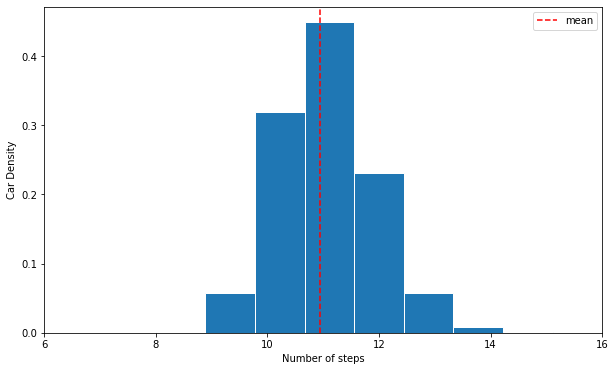

10.937887763328543


In [193]:
plt.figure(figsize = (10, 6))
plt.hist(sim.density, bins = 18, edgecolor = 'white', color = 'C0', density = True)
plt.axvline(np.mean(sim.density), color = 'red', ls = '--', label = 'mean')
plt.xlabel('Number of steps')
plt.ylabel('Car Density')
plt.xlim((6, 16))
plt.legend()
plt.show()

print(np.mean(sim.density))

### 2. Intelligent Driver Model

In [10]:
class VehicleIDM:
    """
    Creates a vehicle and sets its updating rules. 
    
    Args:
        config (dictionary): configuration for a vehicle, can include things like max speed, acceleration, reaction time etc. 
    
    Returns:
        object : a vehicle object with relevant attributes to be on a road
    
    """
    def __init__(self, config={}):
        # Set default configuration
        self.set_default_config()

        # Update configuration
        for attr, val in config.items():
            setattr(self, attr, val)

        # Calculate properties
        self.init_properties()

    def set_default_config(self):    
        self.l = 4 #length of car
        self.s0 = 4 #minimum desired distance between cars
        self.T = 1 #reaction time
        self.v_max = 16 #max speed
        self.a_max = 1.5 #max acceleration
        self.b_max = 4 #comfortable deceleration

        self.path = []  #path followed by the vehicle
        self.current_road_index = 0
 
        self.x = 0  #position 
        self.v = self.v_max  #speed 
        self.a = 0  #acceleration
        self.stopped = False

    def init_properties(self):
        self.sqrt_ab = 2*np.sqrt(self.a_max*self.b_max)
        self._v_max = self.v_max

    def update(self, lead, dt):
        # Update position and velocity
        if self.v + self.a*dt < 0:
            self.x -= 1/2*self.v*self.v/self.a
            self.v = 0
        else:
            self.v += self.a*dt
            self.x += self.v*dt + self.a*dt*dt/2
        
        # Update acceleration
        alpha = 0
        if lead:
            delta_x = lead.x - self.x - lead.l
            delta_v = self.v - lead.v

            alpha = (self.s0 + max(0, self.T*self.v + delta_v*self.v/self.sqrt_ab)) / delta_x

        self.a = self.a_max * (1-(self.v/self.v_max)**4 - alpha**2)

        if self.stopped: 
            self.a = -self.b_max*self.v/self.v_max
        
    def stop(self):
        self.stopped = True

    def unstop(self):
        self.stopped = False

    def slow(self, v):
        self.v_max = v

    def unslow(self):
        self.v_max = self._v_max 

In [11]:
class VehicleGeneratorIDM:
    """
    Creates a list of vehicles using the Vechicle class and set of generation rules to appropriately space out 
    creating the vehicles
    
    Args:
        config (dictionary): configuration for the vehicles, can include things like rate
    
    Returns:
        object : a list of vehicles  
    """
    def __init__(self, sim, config={}):
        self.sim = sim

        # Set default configurations
        self.set_default_config()

        # Update configurations
        for attr, val in config.items():
            setattr(self, attr, val)

        # Calculate properties
        self.init_properties()

    def set_default_config(self):
        """Set default configuration"""
        self.vehicle_rate = 20
        self.vehicles = [
            (1, {})
        ]
        self.last_added_time = 0

    def init_properties(self):
        self.upcoming_vehicle = self.generate_vehicle()

    def generate_vehicle(self):
        """Returns a random vehicle from self.vehicles with random proportions"""
        total = sum(pair[0] for pair in self.vehicles)
        r = randint(1, total+1)
        for (weight, config) in self.vehicles:
            r -= weight
            if r <= 0:
                return VehicleIDM(config)

    def update(self):
        """Add vehicles"""
        if self.sim.t - self.last_added_time >= 60 / self.vehicle_rate:
            # If time elasped after last added vehicle is
            # greater than vehicle_period; generate a vehicle
            road = self.sim.roads[self.upcoming_vehicle.path[0]]      
            if len(road.vehicles) == 0\
               or road.vehicles[-1].x > self.upcoming_vehicle.s0 + self.upcoming_vehicle.l:
                # If there is space for the generated vehicle; add it
                self.upcoming_vehicle.time_added = self.sim.t
                road.vehicles.append(self.upcoming_vehicle)
                # Reset last_added_time and upcoming_vehicle
                self.last_added_time = self.sim.t
            self.upcoming_vehicle = self.generate_vehicle()

In [12]:
class RoadIDM:
    """
    Creates a single road with a list of vehicles on it that follow speed rules and traffic rules on the road 
    
    Args:
        start (tuple): a tuple of coordinates for the start point of the road
        end (tuple): a tuple of coordinates for the end point of the road
    
    Returns:
        object : a road with a list of vehicles and traffic signals generated on it
    
    """
    def __init__(self, start, end):
        self.start = start
        self.end = end

        self.vehicles = deque()
        self.density = len(self.vehicles)

        self.init_properties()

    def init_properties(self):
        self.length = distance.euclidean(self.start, self.end)
        self.angle_sin = (self.end[1]-self.start[1]) / self.length
        self.angle_cos = (self.end[0]-self.start[0]) / self.length
        # self.angle = np.arctan2(self.end[1]-self.start[1], self.end[0]-self.start[0])
        self.has_traffic_signal = False

    def set_traffic_signal(self, signal, group):
        self.traffic_signal = signal
        self.traffic_signal_group = group
        self.has_traffic_signal = True

    @property
    def traffic_signal_state(self):
        if self.has_traffic_signal:
            i = self.traffic_signal_group
            return self.traffic_signal.current_cycle[i]
        return True

    def update(self, dt):
        n = len(self.vehicles)
        self.density = n
        
        if n > 0:
            # Update first vehicle
            self.vehicles[0].update(None, dt)
            # Update other vehicles
            for i in range(1, n):
                lead = self.vehicles[i-1]
                self.vehicles[i].update(lead, dt)

             # Check for traffic signal
            if self.traffic_signal_state:
                # If traffic signal is green or doesn't exist
                # Then let vehicles pass
                self.vehicles[0].unstop()
                for vehicle in self.vehicles:
                    vehicle.unslow()
            else:
                # If traffic signal is red
                #if self.vehicles[0].x 
                if self.vehicles[0].x >= self.length - self.traffic_signal.slow_distance:
                    # Slow vehicles in slowing zone
                    self.vehicles[0].slow(self.traffic_signal.slow_factor*self.vehicles[0]._v_max)
                if self.vehicles[0].x >= self.length - self.traffic_signal.stop_distance and\
                   self.vehicles[0].x <= self.length - self.traffic_signal.stop_distance / 2:
                    # Stop vehicles in the stop zone
                    self.vehicles[0].stop()

In [13]:
class TrafficSignalStatic:
    """
    Creates a traffice signal object that follow a static traffice rule, i.e., a fixed cycle after which the signals change
    their state. 
    
    Args:
        roads (list): contains lists of the index values of paired roads whose signal is coordinated
        config (dictionary): configuration for the traffic signal, can include things like distance, cycle etc.
    
    Returns:
        object : a set of traffice signals for specified roads
    
    """
    def __init__(self, roads, config={}):
        # Initialize roads
        self.roads = roads
        # Set default configuration
        self.set_default_config()
        # Update configuration
        for attr, val in config.items():
            setattr(self, attr, val)
        # Calculate properties
        self.init_properties()

    def set_default_config(self):
        self.cycle = [(False, True), (True, False)]
        self.slow_distance = 50
        self.slow_factor = 0.4
        self.stop_distance = 15

        self.current_cycle_index = 0

        self.last_t = 0

    def init_properties(self):
        for i in range(len(self.roads)):
            for road in self.roads[i]:
                road.set_traffic_signal(self, i)

    @property
    def current_cycle(self):
        return self.cycle[self.current_cycle_index]
    
    def update(self, sim):
        cycle_length = 50
        k = (sim.t // cycle_length) % 2
        self.current_cycle_index = int(k)

In [14]:
TURN_LEFT = 0
TURN_RIGHT = 1
def turn_road(start, end, turn_direction, resolution=15):
    """
    creates a curved roads for turning
    
    Args:
        start (tuple): a tuple of coordinates for the start point of the road
        end (tuple): a tuple of coordinates for the end point of the road
        turn_direction (int): a 0 (left) or 1 (right) value to turn the car 
        resolution (int): number of smaller roads needed to make the whole road
        
    Returns:
        a set of input parameters for the curve_road function
    
    """
    # Get control point
    x = min(start[0], end[0])
    y = min(start[1], end[1])

    if turn_direction == TURN_LEFT:
        control = (
            x - y + start[1],
            y - x + end[0])
    else:
        control = (
            x - y + end[1],
            y - x + start[0])
    return curve_road(start, end, control, resolution=resolution)

In [15]:
class SimulationIDM1:
    """
    Creates a simulation with several roads with vehicles on each road and traffic signals that follow the static signal model 
    It has updating rules that allows a car to follow a path on the grid. 
    
    Args:
        config (dictionary): configuration for the simulation, can include things like delta_t. 
    
    Returns:
        object : a grid of roads with cars following a path
    
    """
    def __init__(self, config={}):
        # Set default configuration
        self.set_default_config()
        # Update configuration
        for attr, val in config.items():
            setattr(self, attr, val)
        self.density = []

    def set_default_config(self):
        self.t = 0.0            # Time keeping
        self.frame_count = 0    # Frame count keeping
        self.dt = 1/60          # Simulation time step
        self.roads = []         # Array to store roads
        self.generators = []
        self.traffic_signals = []

    def create_road(self, start, end):
        road = RoadIDM(start, end)
        self.roads.append(road)
        return road

    def create_roads(self, road_list):
        for road in road_list:
            self.create_road(*road)

    def create_gen(self, config={}):
        gen = VehicleGeneratorIDM(self, config)
        self.generators.append(gen)
        return gen

    def create_signal(self, roads, config={}):
        roads = [[self.roads[i] for i in road_group] for road_group in roads]
        sig = TrafficSignalStatic(roads, config)
        self.traffic_signals.append(sig)
        return sig
   
    def update(self):
        # Update every road
        for road in self.roads:
            road.update(self.dt)
    
        # Add vehicles
        for gen in self.generators:
            gen.update()

        for signal in self.traffic_signals:
            signal.update(self)
        
        d = 0
        # Check roads for out of bounds vehicle
        for road in self.roads:
            #d += len(road.vehicles)
            d += road.density
            if len(road.vehicles) > 1:
                for v in range(1, len(road.vehicles)): 
                    if road.vehicles[v].x > road.vehicles[-1].s0 + road.vehicles[-1].l:
                    #(road.vehicles[v].x + road.vehicles[v].l + 1) >= road.vehicles[-1].x:
                        road.vehicles[v].slow(0.5*road.vehicles[v]._v_max)
                    else:
                        #road.vehicles[v].v = road.vehicles[v]._v_max
                        road.vehicles[v].unslow()
            # If road has no vehicles, continue
            if len(road.vehicles) == 0: continue
            # If not
            vehicle = road.vehicles[0]
            # If first vehicle is out of road bounds
            if vehicle.x >= road.length:
                # If vehicle has a next road
                if vehicle.current_road_index + 1 < len(vehicle.path):
                    # Update current road to next road
                    vehicle.current_road_index += 1
                    # Create a copy and reset some vehicle properties
                    new_vehicle = deepcopy(vehicle)
                    new_vehicle.x = 0
                    # Add it to the next road
                    next_road_index = vehicle.path[vehicle.current_road_index]
                    self.roads[next_road_index].vehicles.append(new_vehicle)
                    
                # In all cases, remove it from its road
                road.vehicles.popleft() 
        self.density.append(d)    
        # Increment time
        self.t += self.dt
        self.frame_count += 1

    def run(self, steps):
        for _ in range(steps):
            self.update()

In [16]:
def road_grid():
    # Play with these
    n = 15
    a = 10
    b = 20
    l = 300

    # Roads
    WEST_INBOUND = ((-320, 10), (-20, 10))
    SOUTH_INBOUND = ((10, 320), (10, 20))
    EAST_INBOUND = ((320, -10), (20, -10))
    NORTH_INBOUND = ((-10, -320), (-10, -20))

    WEST_OUTBOUND = ((-20, -10), (-320, -10))
    SOUTH_OUTBOUND = ((-10, 20), (-10, 320))
    EAST_OUTBOUND = ((20, 10), (320, 10))
    NORTH_OUTBOUND = ((10, -20), (10, -320))

    WEST_STRAIGHT = ((-20, 10), (20, 10))
    SOUTH_STRAIGHT = ((10, 20), (10, -20))
    EAST_STRAIGHT = ((20, -10), (-20, -10))
    NORTH_STRAIGHT = ((-10, -20), (-10, 20))

    WEST_RIGHT_TURN = turn_road((-20, 10), (-10, 20), TURN_RIGHT, n)
    WEST_LEFT_TURN = turn_road((-20, 10), (10, -20), TURN_LEFT, n)

    SOUTH_RIGHT_TURN = turn_road((10, 20), (20, 10), TURN_RIGHT, n)
    SOUTH_LEFT_TURN = turn_road((10, 20), (-20, -10), TURN_LEFT, n)

    EAST_RIGHT_TURN = turn_road((20, -10), (10, -20), TURN_RIGHT, n)
    EAST_LEFT_TURN = turn_road((20, -10), (-10, 20), TURN_LEFT, n)

    NORTH_RIGHT_TURN = turn_road((-10, -20), (-20, -10), TURN_RIGHT, n)
    NORTH_LEFT_TURN = turn_road((-10, -20), (20, 10), TURN_LEFT, n)

    return([ 
    WEST_INBOUND, #0
    SOUTH_INBOUND, #1
    EAST_INBOUND, #2
    NORTH_INBOUND, #3

    WEST_OUTBOUND, #4
    SOUTH_OUTBOUND, #5 
    EAST_OUTBOUND, #6
    NORTH_OUTBOUND, #7

    WEST_STRAIGHT, #8
    SOUTH_STRAIGHT, #9 
    EAST_STRAIGHT, #10
    NORTH_STRAIGHT, #11

    *WEST_RIGHT_TURN, #12
    *SOUTH_RIGHT_TURN, #12+n
    *EAST_RIGHT_TURN, #12 +2n
    *NORTH_RIGHT_TURN, #12 +3n 
    
    *WEST_LEFT_TURN,
    *SOUTH_LEFT_TURN,
    *EAST_LEFT_TURN,
    *NORTH_LEFT_TURN])

n = 15
def road(a): return range(a, a+n)
def car_paths(rate):
    return({
'vehicle_rate': rate,
'vehicles':[
    [3, {'path': [0, 8, 6]}],
    [3, {'path': [0, *road(12), 5]}],

    [1, {'path': [1, 9, 7]}],
    [1, {'path': [1, *road(12+n), 6]}],

    [3, {'path': [2, 10, 4]}],
    [2, {'path': [2, *road(12+2*n), 7]}],

    [1, {'path': [3, 11, 5]}],
    [1, {'path': [3, *road(12+3*n), 4]}],
]})


In [17]:
sim = SimulationIDM1()
sim.create_roads(road_grid())
sim.create_gen(car_paths(rate = 30))
sim.create_signal([[0, 2], [1, 3]])

#sim.run(steps = 100)
# Start simulation
win = Window(sim)
win.zoom = 3
win.run(steps_per_update=10)

In [18]:
class TrafficSignalDynamic:
    """
    Creates a traffic signal object that follow a dynamic traffic rule, i.e., follows a fixed cycle unless there is a higher
    density in one of the roads whose signal is red. 
    
    Args:
        roads (list): contains lists of the index values of paired roads whose signal is coordinated
        config (dictionary): configuration for the traffic signal, can include things like distance, cycle etc.
    
    Returns:
        object : a set of traffic signals for specified roads
    
    """
    def __init__(self, signal_roads, config={}):
        # Initialize roads
        self.roads = signal_roads
        # Set default configuration
        self.set_default_config()
        # Update configuration
        for attr, val in config.items():
            setattr(self, attr, val)
        # Calculate properties
        self.init_properties()

    def set_default_config(self):
        self.cycle = [(False, True), (True, False)]
        self.slow_distance = 50
        self.slow_factor = 0.4
        self.stop_distance = 15

        self.current_cycle_index = 0

        self.last_t = 0
        self.k = 0

    def init_properties(self):
        for i in range(len(self.roads)):
            for road in self.roads[i]:
                road.set_traffic_signal(self, i)

    @property
    def current_cycle(self):
        return self.cycle[self.current_cycle_index]
    
    def update(self, sim):
        W, S, E, N = sim.roads[0:4]
        WE_density = W.density + E.density
        NS_density = N.density + S.density
        if self.k == 1:
            if (W.density > 5 or E.density > 5) and NS_density < 20:
                self.k = 1
            else:
                cycle_length = 50
                self.k = (sim.t // cycle_length) % 2
                self.current_cycle_index = int(self.k)
        elif self.k == 0:
            if (N.density > 5 or S.density > 5) and WE_density < 20:
                self.k = 0
            else:
                cycle_length = 50
                self.k = (sim.t // cycle_length) % 2
                self.current_cycle_index = int(self.k)
        

In [19]:
class SimulationIDM2:
    """
    Creates a simulation with several roads with vehicles on each road and traffic signals that follow the dynamic signal model 
    It has updating rules that allows a car to follow a path on the grid. 
    
    Args:
        config (dictionary): configuration for the simulation, can include things like delta_t. 
    
    Returns:
        object : a grid of roads with cars following a path
    
    """
    def __init__(self, config={}):
        # Set default configuration
        self.set_default_config()
        # Update configuration
        for attr, val in config.items():
            setattr(self, attr, val)
        self.density = []

    def set_default_config(self):
        self.t = 0.0            # Time keeping
        self.frame_count = 0    # Frame count keeping
        self.dt = 1/60          # Simulation time step
        self.roads = []         # Array to store roads
        self.generators = []
        self.traffic_signals = []

    def create_road(self, start, end):
        road = RoadIDM(start, end)
        self.roads.append(road)
        return road

    def create_roads(self, road_list):
        for road in road_list:
            self.create_road(*road)

    def create_gen(self, config={}):
        gen = VehicleGeneratorIDM(self, config)
        self.generators.append(gen)
        return gen

    def create_signal(self, roads, config={}):
        roads = [[self.roads[i] for i in road_group] for road_group in roads]
        sig = TrafficSignalDynamic(roads, config)
        self.traffic_signals.append(sig)
        return sig
   
    def update(self):
        # Update every road
        for road in self.roads:
            road.update(self.dt)
    
        # Add vehicles
        for gen in self.generators:
            gen.update()

        for signal in self.traffic_signals:
            signal.update(self)
        
        d = 0
        # Check roads for out of bounds vehicle
        for road in self.roads:
            #d += len(road.vehicles)
            d += road.density
            if len(road.vehicles) > 1:
                for v in range(1, len(road.vehicles)): 
                    if road.vehicles[v].x > road.vehicles[-1].s0 + road.vehicles[-1].l:
                    #(road.vehicles[v].x + road.vehicles[v].l + 1) >= road.vehicles[-1].x:
                        road.vehicles[v].slow(0.5*road.vehicles[v]._v_max)
                    else:
                        #road.vehicles[v].v = road.vehicles[v]._v_max
                        road.vehicles[v].unslow()
            # If road has no vehicles, continue
            if len(road.vehicles) == 0: continue
            # If not
            vehicle = road.vehicles[0]
            # If first vehicle is out of road bounds
            if vehicle.x >= road.length:
                # If vehicle has a next road
                if vehicle.current_road_index + 1 < len(vehicle.path):
                    # Update current road to next road
                    vehicle.current_road_index += 1
                    # Create a copy and reset some vehicle properties
                    new_vehicle = deepcopy(vehicle)
                    new_vehicle.x = 0
                    # Add it to the next road
                    next_road_index = vehicle.path[vehicle.current_road_index]
                    self.roads[next_road_index].vehicles.append(new_vehicle)
                    
                # In all cases, remove it from its road
                road.vehicles.popleft() 
        self.density.append(d)    
        # Increment time
        self.t += self.dt
        self.frame_count += 1

    def run(self, steps):
        for _ in range(steps):
            self.update()

In [20]:
sim = SimulationIDM2()
sim.create_roads(road_grid())
sim.create_gen(car_paths(rate = 30))
sim.create_signal([[0, 2], [1, 3]])

#sim.run(steps = 100)
# Start simulation
win = Window(sim)
win.zoom = 3
win.run(steps_per_update=10)

In [200]:

sim1 = SimulationIDM1()
sim1.create_roads(road_grid())
sim1.create_gen(car_paths(rate = 30))
sim1.create_signal([[0, 2], [1, 3]])

sim2 = SimulationIDM2()
sim2.create_roads(road_grid())
sim2.create_gen(car_paths(rate = 30))
sim2.create_signal([[0, 2], [1, 3]])


win1 = WindowSimulation(sim1)
win2 = WindowSimulation(sim2)
trials = 10000
win1.run(steps_per_update=10, trials = trials)
win2.run(steps_per_update=10, trials = trials)

In [123]:
len(sim1.density)

100000

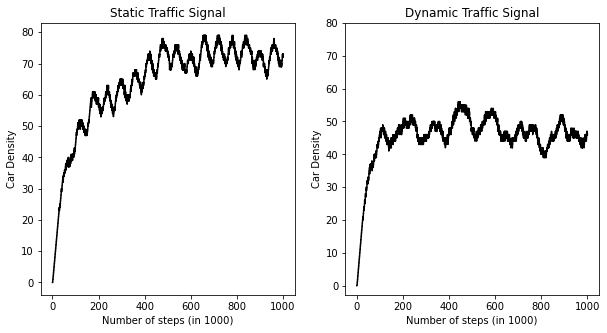

In [203]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), sharex = True)
x = np.linspace(0, 1000, trials*10)
# plt.hist(sim.density, edgecolor = 'white')
ax1.plot(x, sim1.density, color = 'black')
ax1.set_ylabel('Car Density')
ax1.set_xlabel('Number of steps (in 1000)')
ax1.set_title('Static Traffic Signal')

ax2.plot(x, sim2.density, color = 'black')
ax2.set_xlabel('Number of steps (in 1000)')
ax2.set_ylabel('Car Density')
ax2.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
ax2.set_title('Dynamic Traffic Signal')

plt.show()

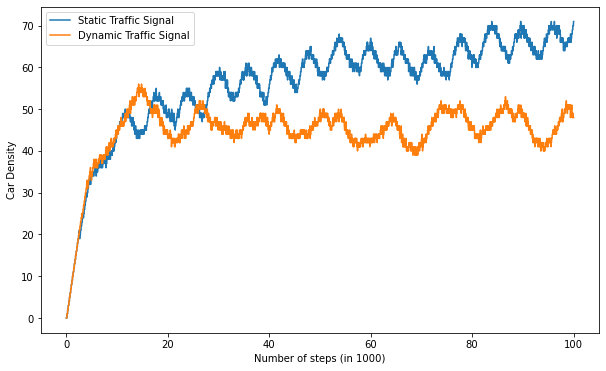

In [133]:
x = np.linspace(0, 100, trials*10)
plt.figure(figsize = (10, 6))
plt.plot(x, sim1.density, color = 'C0', label = 'Static Traffic Signal')
plt.plot(x, sim2.density, color = 'C1', label = 'Dynamic Traffic Signal')
plt.xlabel('Number of steps (in 1000)')
plt.ylabel('Car Density')
plt.legend()
plt.show()

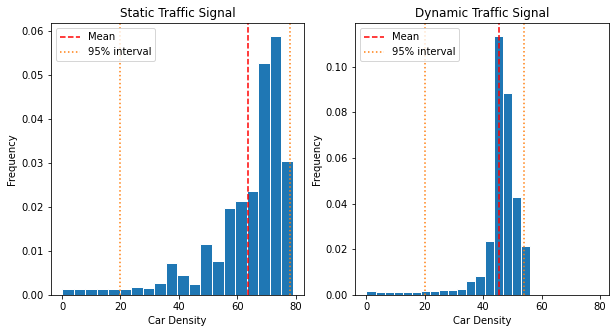

Static Traffic Signal model mean: 63.8
Static Traffic Signal model 95% confidence interval: (20.0, 78.0)
--------------------------------------------------------------
Dynamic Traffic Signal model mean: 45.3
Dynamic Traffic Signal model 95% confidence interval: (20.0, 54.0)


In [204]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5), sharex = True)

ax1.hist(sim1.density, bins = 20, edgecolor = 'white', density = True)
ax1.set_xlabel('Car Density')
ax1.set_ylabel('Frequency')
ax1.set_title('Static Traffic Signal')
ax1.axvline(np.mean(sim1.density), ls = '--', color = 'red', label = 'Mean')
ax1.axvline(np.quantile(sim1.density, 0.025), ls = ':', color = 'C1', label = '95% interval')
ax1.axvline(np.quantile(sim1.density, 0.975), ls = ':', color = 'C1')
ax1.legend(loc = 'upper left')

ax2.hist(sim2.density, bins = 18, edgecolor = 'white', density = True)
ax2.set_xlabel('Car Density')
ax2.set_ylabel('Frequency')
ax2.set_title('Dynamic Traffic Signal')
ax2.axvline(np.mean(sim2.density), ls = '--', color = 'red', label = 'Mean')
ax2.axvline(np.quantile(sim2.density, 0.025), ls = ':', color = 'C1', label = '95% interval')
ax2.axvline(np.quantile(sim2.density, 0.975), ls = ':', color = 'C1')
ax2.legend(loc = 'upper left')

plt.show()

print(f'Static Traffic Signal model mean: {np.mean(sim1.density):.3}')
print(f'Static Traffic Signal model 95% confidence interval: ({np.quantile(sim1.density, 0.025):.3}, {np.quantile(sim1.density, 0.975):.3})')
print('--------------------------------------------------------------')
print(f'Dynamic Traffic Signal model mean: {np.mean(sim2.density):.3}')
print(f'Dynamic Traffic Signal model 95% confidence interval: ({np.quantile(sim2.density, 0.025):.3}, {np.quantile(sim2.density, 0.975):.3})')

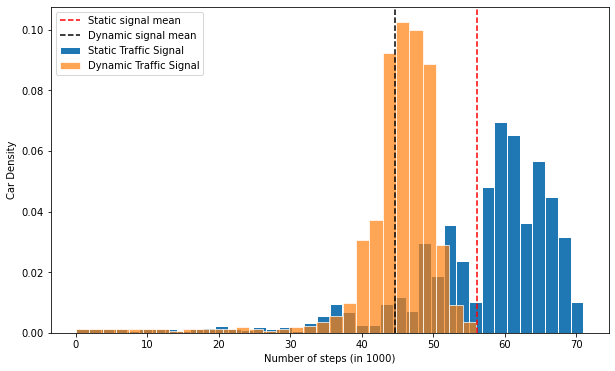

In [170]:
plt.figure(figsize = (10, 6))
plt.hist(sim1.density, bins = 40, edgecolor = 'white', color = 'C0', label = 'Static Traffic Signal', density = True)
plt.hist(sim2.density, bins = 30, edgecolor = 'white', color = 'C1', label = 'Dynamic Traffic Signal', alpha = 0.7, density = True)
plt.axvline(np.mean(sim1.density), color = 'red', ls = '--', label = 'Static signal mean')
plt.axvline(np.mean(sim2.density), color = 'black', ls = '--', label = 'Dynamic signal mean')
plt.xlabel('Number of steps (in 1000)')
plt.ylabel('Car Density')
plt.legend()
plt.show()